# ノート 10: ハイパーパラメータの探索

### 目標: ハイパーパラメータのチューニング例を示します

### 背景

ML のドキュメントを見ると多くの場合たくさんのオプションや引数の記載を見つけると思います。
例えば scikit-learn の [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)クラスのドキュメントを見てみてください。
オプションや引数の多くはハイパーパラメータと呼ばれるものです。性能が良くなるか悪くなるかは分かりませんが、ハイパーパラメータは ML モデルに関して人が選択的に変更可能なパラメータです。
ML モデルが扱う問題は毎回異なるので、ハイパーパラメータを選択することでモデルの性能をチューニングできることがよくあります。
このノートではランダムフォレストモデルを例にしてハイパーパラメータのチューニングについて学びます。


### パッケージのインポートとデータの読み込み

ランダムフォレストモデルを使った回帰問題を例にします。回帰問題で使ったデータを読み込んで正規化します。


In [1]:
import sys
import numpy as np

sys.path.insert(1, "../scripts/")
from aux_functions import load_n_combine_df

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'

In [2]:
(X_train, y_train), (X_validate, y_validate), _ = load_n_combine_df(
    path_to_data="../datasets/sevir/",
    features_to_keep=np.arange(0, 36, 1),  # 36個すべての特徴量を使う
    class_labels=False,  # ラベル付けは行わない
    dropzeros=True,  # 発雷数1以上のデータのみ使う
)


# 正規化
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

### パラメータ sweeps を決める

scikit-learn の[RandomForestRegressor クラスのドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)を確認しましょう。

オプション引数として様々なパラメータがあります。系統的に変化させてチューニングしていきましょう。特に、

1. 「木の深さ（枝の数）」を表すパラメータ `max_depth`
2. 「木の数」を表すパラメータ `n_estimators`

について詳しく見ていきます。

より多くのハイパーパラメータをテストする手法もありますが、まずは一般的な方法でテストしてみましょう。
木の深さを 1 から 10 まで変化させて徐々に増やしていきます。木の数は 1, 5, 10, 25, 50, 100 とします。
論文のハイパーパラメータのチューニング（3 節 c.2）では 木の数を 1000 にしてテストを行いましたが、
木の深さが深くなるほど、木の本数が多くなるほどモデルの学習に時間がかかります。
このチュートリアルではハイパーパラメータのチューニング法を学ぶことが目的なので木の数を 100 本 に減らして計算時間を削減します。


In [3]:
# テストする木の深さ
depth = np.arange(1, 11, 1)
# テストする木の数
n_tree = [1, 5, 10, 25, 50, 100]

# テストする [木の数, 木の深さ] の組み合わせ
sets = [[n, d] for n in n_tree for d in depth]  # リスト内包の場合後ろ側のループが内側になる

# 組み合わせ一覧
print(len(sets))
for i in range(0, len(sets), 10):
    print(sets[i : i + 10])

60
[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10]]
[[5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10]]
[[10, 1], [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9], [10, 10]]
[[25, 1], [25, 2], [25, 3], [25, 4], [25, 5], [25, 6], [25, 7], [25, 8], [25, 9], [25, 10]]
[[50, 1], [50, 2], [50, 3], [50, 4], [50, 5], [50, 6], [50, 7], [50, 8], [50, 9], [50, 10]]
[[100, 1], [100, 2], [100, 3], [100, 4], [100, 5], [100, 6], [100, 7], [100, 8], [100, 9], [100, 10]]


全部で 60 個のハイパーパラメータの組み合わせをテストします。
指標を計算する関数を定義しておきましょう。


In [4]:
# ユーティリティ関数
from gewitter_functions import get_bias, get_mae, get_rmse, get_r2


def get_metrics(model, X, y):
    """
    学習モデルの指標を計算する

    Args:
      mode: 学習モデル
      X: 入力データ
      y: 出力データ

    Returns:
      bias, mae, rmse, r2
    """
    yhat = model.predict(X)
    mae = get_mae(y, yhat)
    rmse = get_rmse(y, yhat)
    bias = get_bias(y, yhat)
    r2 = get_r2(y, yhat)

    return np.array([bias, mae, rmse, r2])

ハイパーパラメータのテストを行いましょう。
次のコードの実行には並列数 n_jobs を 4 にした場合で 20 分ほどかかります。
時間がない場合はこのセルの実行を飛ばしてあらかじめ計算済みのデータを読み込んでください。


In [5]:
import tqdm  # 進行状況を表示するパッケージ

# ランダムフォレストモデルのクラス
from sklearn.ensemble import RandomForestRegressor

for i, s in enumerate(tqdm.tqdm(sets)):
    # モデルの初期化、ハイパーパラメータはコンストラクタの引数で指定する
    reg = RandomForestRegressor(
        n_estimators=s[0],  # 木の数
        max_depth=s[1],  # 木の深さ
        n_jobs=4,  # 並列実行数
    )
    # モデルの学習
    reg.fit(X_train, y_train)
    # 訓練データ、検証データについて指標を計算
    met_train = get_metrics(reg, X_train, y_train)
    met_val = get_metrics(reg, X_validate, y_validate)

    # 結果を結合して一つにまとめていく
    if i == 0:
        all_scores_val = met_val
        all_scores_train = met_train
    else:
        all_scores_val = np.vstack([all_scores_val, met_val])
        all_scores_train = np.vstack([all_scores_train, met_train])

    # メモリ開放
    del reg

100%|██████████| 60/60 [15:20<00:00, 15.34s/it]


結果をデータフレームにして保存しておきます。


In [6]:
import pandas as pd
from pathlib import Path

df_val = pd.DataFrame(
    all_scores_val,
    columns=["Bias", "MeanAbsoluteError", "RootMeanSquaredError", "Rsquared"],
)
df_train = pd.DataFrame(
    all_scores_train,
    columns=["Bias", "MeanAbsoluteError", "RootMeanSquaredError", "Rsquared"],
)

save_dir = Path("../datasets/hyperparametersearch")
if not save_dir.exists():
    save_dir.mkdir(parents=True)
df_val.to_csv(save_dir / "validation_metrics.csv", index=False)
df_train.to_csv(save_dir / "train_metrics.csv", index=False)

ハイパーパラメータのテストを飛ばした場合は次のセルを実行してあらかじめ計算した結果を読み込んでください。


In [7]:
import pandas as pd
from pathlib import Path


save_dir = Path("../datasets/hyperparametersearch")
df_val = pd.read_csv(save_dir / "validation_metrics.csv")
df_train = pd.read_csv(save_dir / "train_metrics.csv")
df_val.head()

,Bias,MeanAbsoluteError,RootMeanSquaredError,Rsquared
0,8.980250,110.995718,178.546646,0.369178
1,6.064462,97.973686,172.098079,0.413922
2,7.964392,90.847980,162.648035,0.476519
3,19.782506,78.187883,147.570577,0.569074
4,20.529644,76.902462,146.906260,0.572945


60 個のハイパーパラメータの異なるモデルの学習ができたので設定によるモデルの性能の違いを見ていきます。


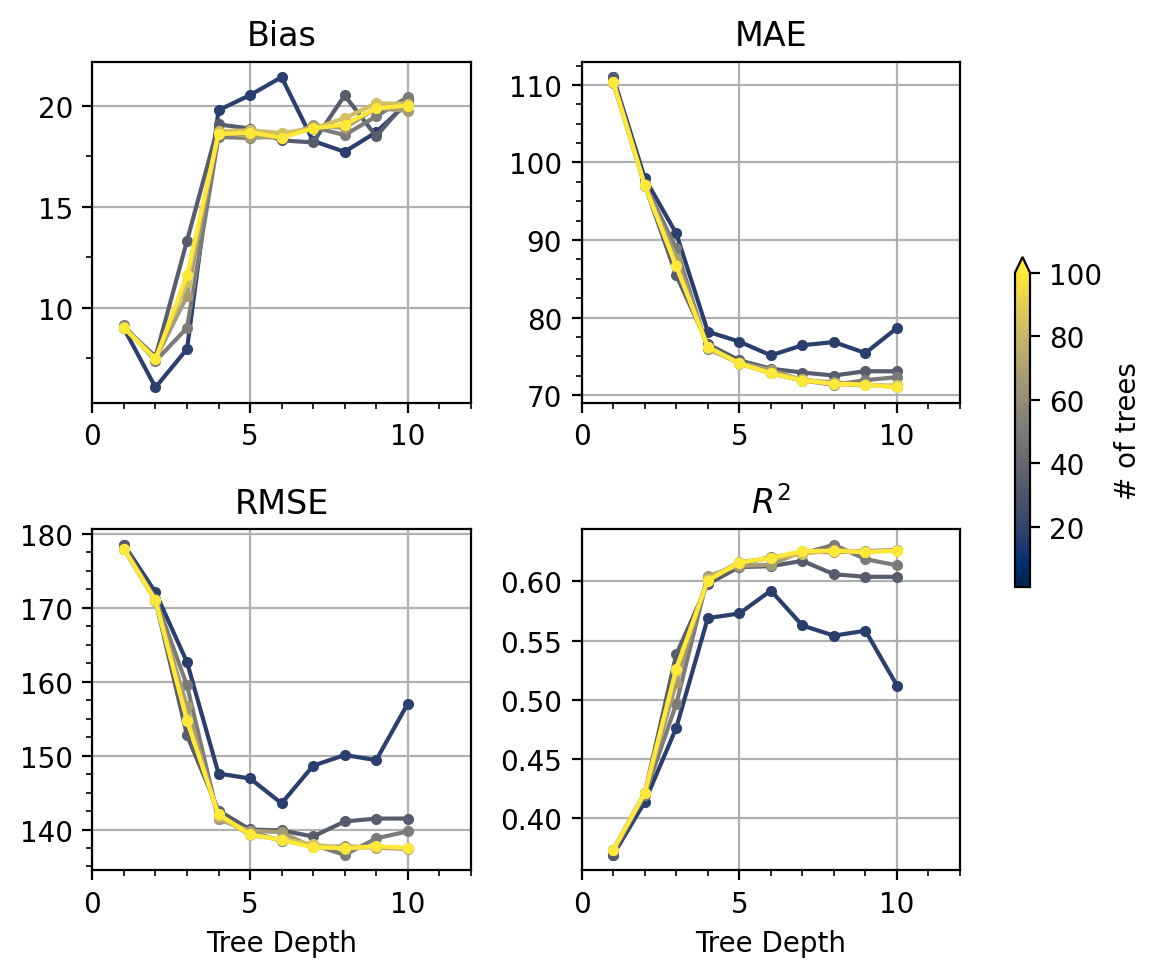

In [8]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator

# カラーバー作成のユーティリティ
from aux_functions import make_colorbar


fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.ravel()

# カラーマップの設定（色が木の数を表す）
cmap = matplotlib.cm.cividis
norm = matplotlib.colors.BoundaryNorm(n_tree, cmap.N, extend="both")
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

titles = ["Bias", "MAE", "RMSE", r"$R^{2}$"]
for j, ax in enumerate(axes):
    for i, ii in enumerate(n_tree):
        color_choice = scalarMap.to_rgba(ii)
        ax.plot(
            np.arange(1, 11, 1),
            df_val.iloc[(i * 10) : (i + 1) * 10, j].to_numpy(),
            "o-",
            color=color_choice,
            ms=3,
        )

        ax.set_title(titles[j])
        ax.set_xlim([0, 12])
        ax.grid("on")

        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(2.5))


# 軸ラベルは一部のみ
axes[2].set_xlabel("Tree Depth")
axes[3].set_xlabel("Tree Depth")

# カラーバー
ax_cbar = fig.add_axes([1.025, 0.4, 0.015, 0.33])
cbar = make_colorbar(ax_cbar, 1, 100, cmap)
cbar.set_label("# of trees")


fig.tight_layout()

x 軸は木の深さ、色が木の数（暗いほど少なく、明るいほど多い）、y 軸は各指標の値を示しています。

木の数は予測性能に大きな影響があるように思ったかもしれませんが、
図から分かるように（また、論文で指摘したように）木の数が 1 本の場合（=決定木）との比較を除き
全体的なパフォーマンスにはそれほど大きな向上は見られません。
また、木の深さが 5 を超えるとモデルの性能に差がなくなっているように見えます。

どのハイパーパラメータの設定がよいかを正しく評価するには訓練データを使った予測の指標も含めて評価する必要があります。
これは、モデルが過学習をしているかどうかの評価になります。
過学習の場合は訓練データの予測性能は非常によくなりますが、検証データの予測性能はあまりよくありません。
訓練データの予測指標をプロットして比較することで
ハイパーパラメータを変化させて訓練データの予測指標が良くなっても検証データの予測が悪化し始める（つまり過学習が強まる）点を探すことができます。
訓練データについても同じ図をプロットしてみましょう。

（注）元ノートの 2 段落目の「the number of trees」は「the tree depth」の誤りではないかと思われる


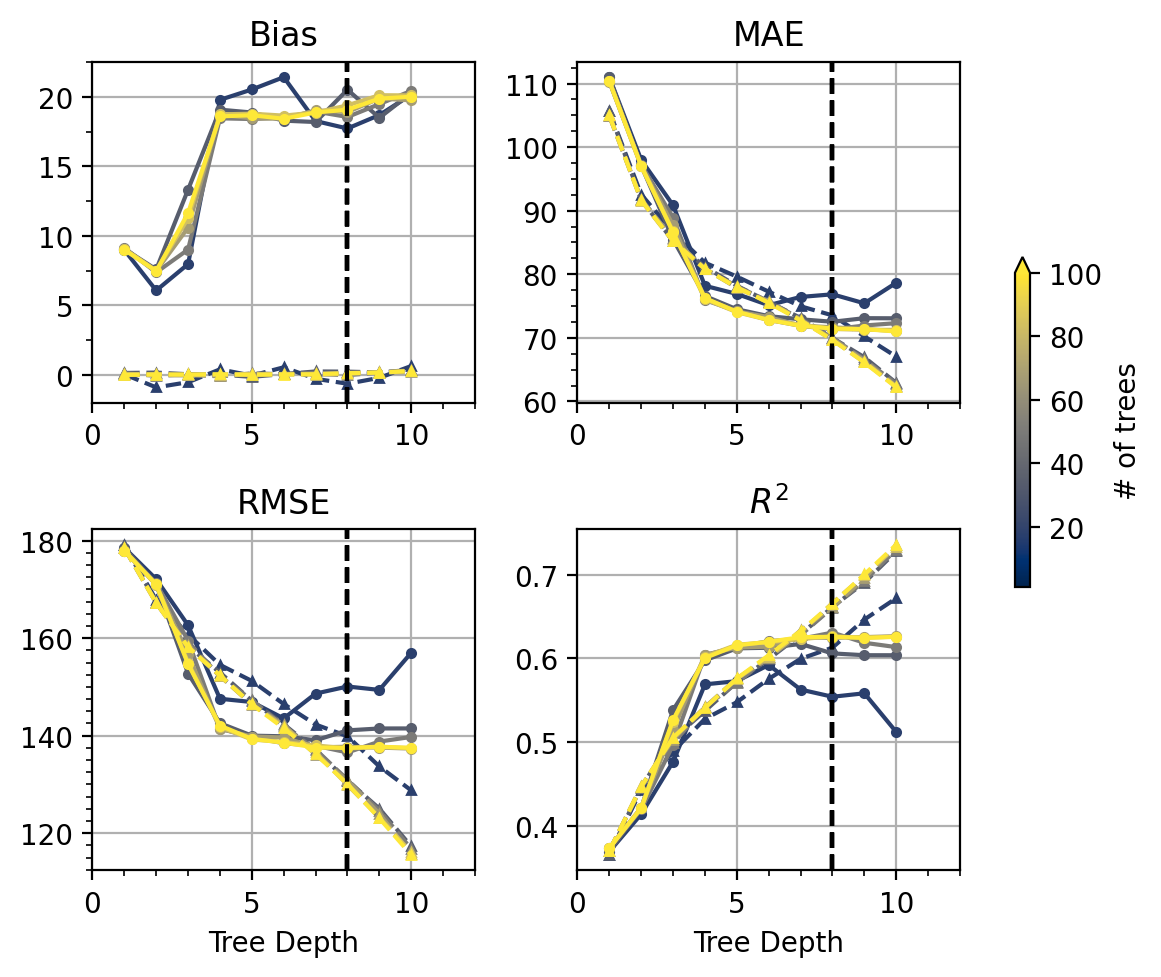

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes = axes.ravel()

# カラーマップの設定（色が木の数を表す）
cmap = matplotlib.cm.cividis
norm = matplotlib.colors.BoundaryNorm(n_tree, cmap.N, extend="both")
scalarMap = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

titles = ["Bias", "MAE", "RMSE", r"$R^{2}$"]
for j, ax in enumerate(axes):
    for i, ii in enumerate(n_tree):
        color_choice = scalarMap.to_rgba(ii)
        ax.plot(
            np.arange(1, 11, 1),
            df_val.iloc[(i * 10) : (i + 1) * 10, j].to_numpy(),
            "o-",
            color=color_choice,
            ms=3,
        )
        ax.plot(
            np.arange(1, 11, 1),
            df_train.iloc[(i * 10) : (i + 1) * 10, j].to_numpy(),
            "^--",
            color=color_choice,
            ms=3,
        )
        ax.axvline(8, ls="--", color="k")

        ax.set_title(titles[j])
        ax.set_xlim([0, 12])
        ax.grid("on")

        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(2.5))


# 軸ラベルは一部のみ
axes[2].set_xlabel("Tree Depth")
axes[3].set_xlabel("Tree Depth")

# カラーバー
ax_cbar = fig.add_axes([1.025, 0.4, 0.015, 0.33])
cbar = make_colorbar(ax_cbar, 1, 100, cmap)
cbar.set_label("# of trees")


fig.tight_layout()

破線が訓練データ、実践が検証データの予測を表します。
また、過学習が始まる前に性能が最もよくなっていると思われる木の深さの位置に黒い破線を引いています。
木の深さが 8 のとき訓練データの $R^{2}$ が検証データを上回っていますが、
他の指標は 5、6、7 の場合とそれほど変わりません。
このことからランダムフォレストのハイパーパラメータは木の数 2 以上、深さ 8 とするのが良いモデルであると考えられます。

ハイパーパラメータチューニングの方法の一例を示しました。ぜひ他のモデルでも試してみてください。
